In [ ]:
fromfrom google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory,image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading Data

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
directory = "/content/drive/MyDrive/FinalDataset/SplittedDatasetFinal"
train_dir = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train"
test_dir = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/test"


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2250 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


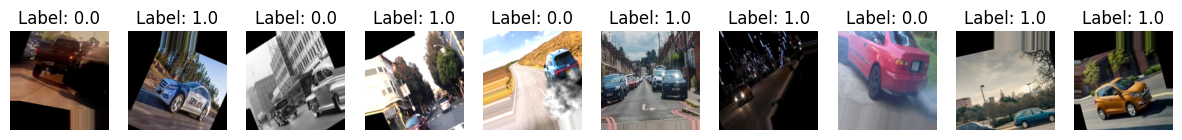

In [ ]:
class_names = ['WithPollution', 'WithoutPollution'] # inspect a subset of augmented images from the training dataset along with their corresponding labels to verify
import matplotlib.pyplot as plt

num_images = 10

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    batch = train_generator.next()
    image = batch[0][0]
    label = batch[1][0]
    axes[i].imshow(image)
    axes[i].set_title('Label: {}'.format(label))
    axes[i].axis('off')

plt.show()


In [ ]:
class_names

['WithPollution', 'WithoutPollution']

## MobileNet-V2

In [ ]:
input_shape = IMG_SIZE + (3,)

In [ ]:
def final_mobilev2(image_shape=IMG_SIZE):


    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False                         #exclude the final fully connected layers of the MobileNetV2 model,
                                                         #and weights is set to 'imagenet' to load pre-trained weights from ImageNet.
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    prediction_layer = tfl.Dense(1)

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [ ]:
final_mobilev2 = final_mobilev2(IMG_SIZE)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.001
final_mobilev2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 40
history = final_mobilev2.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/40
70/70 [==============================] - 1267s 18s/step - loss: 0.7316 - accuracy: 0.4810 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/40
70/70 [==============================] - 48s 692ms/step - loss: 0.7036 - accuracy: 0.5045 - val_loss: 0.7093 - val_accuracy: 0.5000
Epoch 3/40
70/70 [==============================] - 46s 656ms/step - loss: 0.6923 - accuracy: 0.5199 - val_loss: 0.7056 - val_accuracy: 0.5000
Epoch 4/40
70/70 [==============================] - 46s 665ms/step - loss: 0.6834 - accuracy: 0.5276 - val_loss: 0.7002 - val_accuracy: 0.5000
Epoch 5/40
70/70 [==============================] - 46s 656ms/step - loss: 0.6700 - accuracy: 0.5425 - val_loss: 0.7053 - val_accuracy: 0.5000
Epoch 6/40
70/70 [==============================] - 48s 689ms/step - loss: 0.6693 - accuracy: 0.5461 - val_loss: 0.7093 - val_accuracy: 0.5000
Epoch 7/40
70/70 [==============================] - 46s 657ms/step - loss: 0.6647 - accuracy: 0.5506 - val_loss: 0.7254 - val_accuracy: 0.5000

In [ ]:
final_mobilev2.save("/content/drive/MyDrive/PollutionDetectionMobileNetV2Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


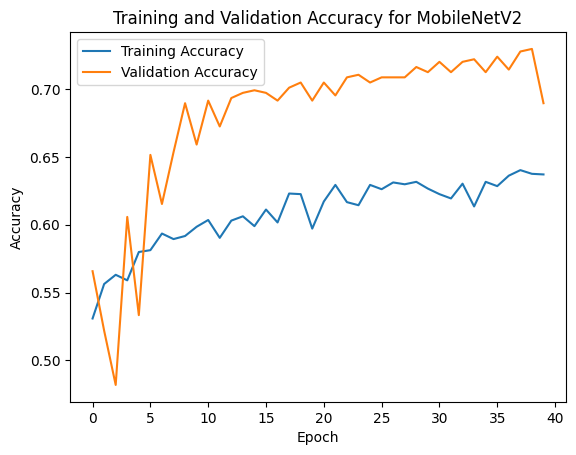

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MobileNetV2')
plt.legend()
plt.show()

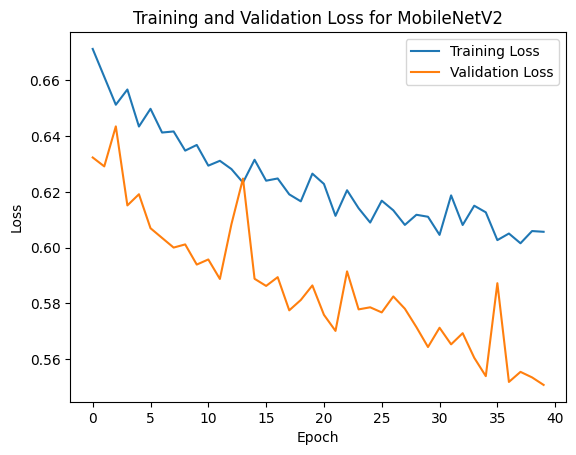

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for MobileNetV2')
plt.legend()
plt.show()

17/17 [==============================] - 4s 247ms/step


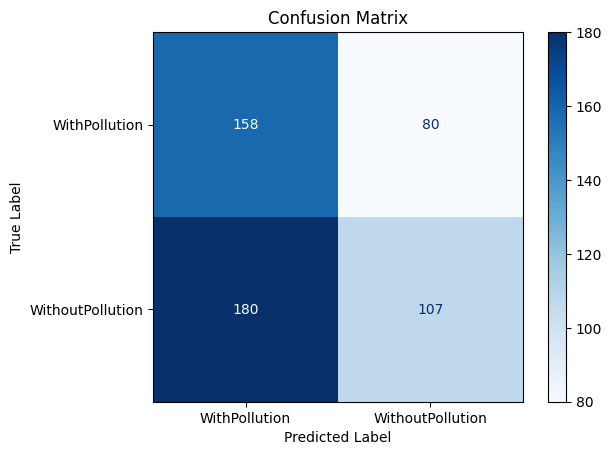

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have predictions and true labels
y_pred = final_mobilev2.predict(test_generator)
y_true = test_generator.classes

# Convert probabilities to class labels
y_pred_classes = (y_pred > 0.4).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have predictions and true labels
y_pred = final_mobilev2.predict(test_generator)
y_true = test_generator.classes

# Convert probabilities to class labels
y_pred_classes = (y_pred > 0.4).astype(int)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


17/17 [==============================] - 3s 155ms/step
                  precision    recall  f1-score   support

   WithPollution       0.46      0.66      0.55       238
WithoutPollution       0.57      0.37      0.45       287

        accuracy                           0.50       525
       macro avg       0.52      0.51      0.50       525
    weighted avg       0.52      0.50      0.49       525



## **MobileNet V3**

In [ ]:
def final_mobilev3(image_shape=IMG_SIZE):


    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    prediction_layer = tfl.Dense(1)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [ ]:
final_mobilev3 = final_mobilev3(IMG_SIZE)

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.001
final_mobilev3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 20
history2 = final_mobilev3.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/20
69/69 [==============================] - 46s 586ms/step - loss: 0.6999 - accuracy: 0.4655 - val_loss: 0.6986 - val_accuracy: 0.4533
Epoch 2/20
69/69 [==============================] - 39s 560ms/step - loss: 0.6933 - accuracy: 0.4642 - val_loss: 0.6888 - val_accuracy: 0.4533
Epoch 3/20
69/69 [==============================] - 48s 704ms/step - loss: 0.6975 - accuracy: 0.4664 - val_loss: 0.6888 - val_accuracy: 0.4533
Epoch 4/20
69/69 [==============================] - 38s 555ms/step - loss: 0.6947 - accuracy: 0.4628 - val_loss: 0.6888 - val_accuracy: 0.4533
Epoch 5/20
69/69 [==============================] - 38s 556ms/step - loss: 0.6946 - accuracy: 0.4660 - val_loss: 0.6902 - val_accuracy: 0.4533
Epoch 6/20
69/69 [==============================] - 42s 610ms/step - loss: 0.6966 - accuracy: 0.4596 - val_loss: 0.6933 - val_accuracy: 0.4533
Epoch 7/20
69/69 [==============================] - 38s 552ms/step - loss: 0.6939 - accuracy: 0.4655 - val_loss: 0.6907 - val_accuracy: 0.4533

In [ ]:
final_mobilev3.save("/content/drive/MyDrive/PollutionDetection/MobileNetV3Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


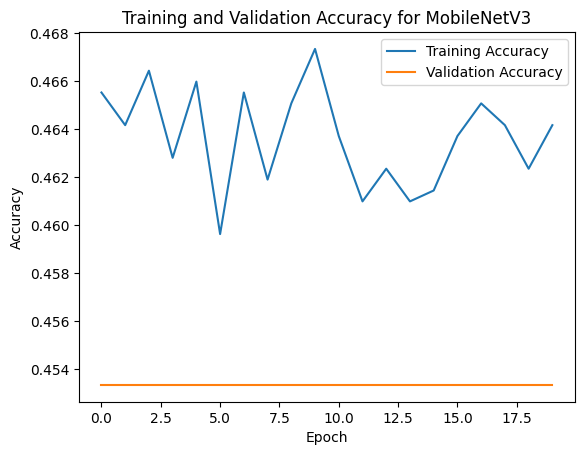

In [ ]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MobileNetV3')
plt.legend()
plt.show()

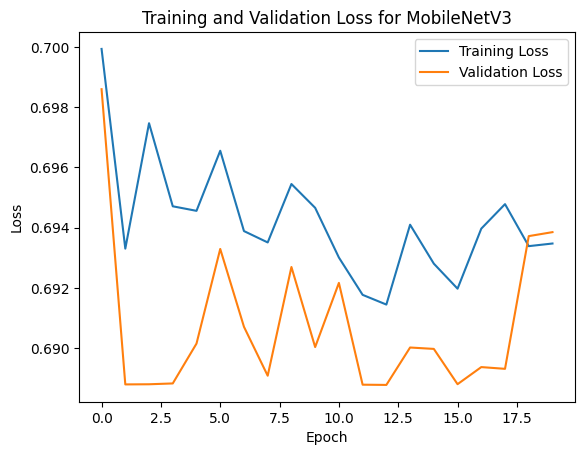

In [ ]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for MobileNetV3')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = final_mobilev3.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_generator], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MobileNetV3')
plt.show()



In [ ]:
final_mobilev3.evaluate(test_generator)

17/17 [==============================] - 3s 154ms/step - loss: 0.6939 - accuracy: 0.4533


[0.6938551068305969, 0.4533333480358124]

## **Inception V3**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model


In [ ]:
input_shape = (224, 224, 3)
# Create the InceptionV3 model
inception_v3 = create_inceptionv3_model(input_shape)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
inception_v3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [ ]:
inception_v3.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history3 = inception_v3.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/10
69/69 [==============================] - 40s 586ms/step - loss: 0.2690 - accuracy: 0.8875 - val_loss: 0.2253 - val_accuracy: 0.9067
Epoch 2/10
69/69 [==============================] - 41s 597ms/step - loss: 0.2646 - accuracy: 0.8925 - val_loss: 0.2697 - val_accuracy: 0.8933
Epoch 3/10
69/69 [==============================] - 51s 745ms/step - loss: 0.2515 - accuracy: 0.8956 - val_loss: 0.2395 - val_accuracy: 0.9029
Epoch 4/10
69/69 [==============================] - 40s 575ms/step - loss: 0.2669 - accuracy: 0.8870 - val_loss: 0.2170 - val_accuracy: 0.9105
Epoch 5/10
69/69 [==============================] - 40s 580ms/step - loss: 0.2564 - accuracy: 0.8897 - val_loss: 0.2128 - val_accuracy: 0.9143
Epoch 6/10
69/69 [==============================] - 40s 576ms/step - loss: 0.2497 - accuracy: 0.8920 - val_loss: 0.2157 - val_accuracy: 0.9105
Epoch 7/10
69/69 [==============================] - 39s 571ms/step - loss: 0.2461 - accuracy: 0.8984 - val_loss: 0.2130 - val_accuracy: 0.9124

In [ ]:
inception_v3.save("/content/drive/MyDrive/PollutionDetection/InceptionV3model.h5")

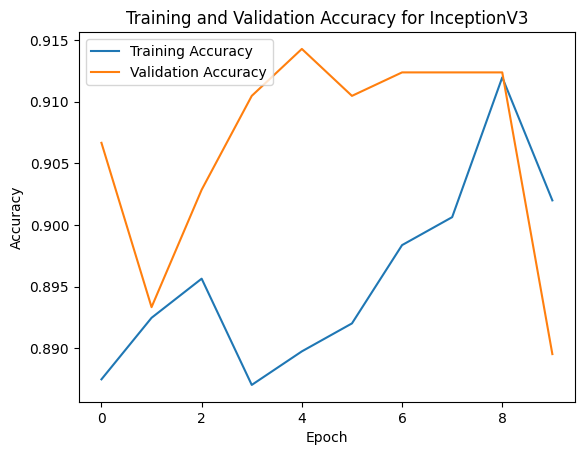

In [ ]:
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for InceptionV3')
plt.legend()
plt.show()

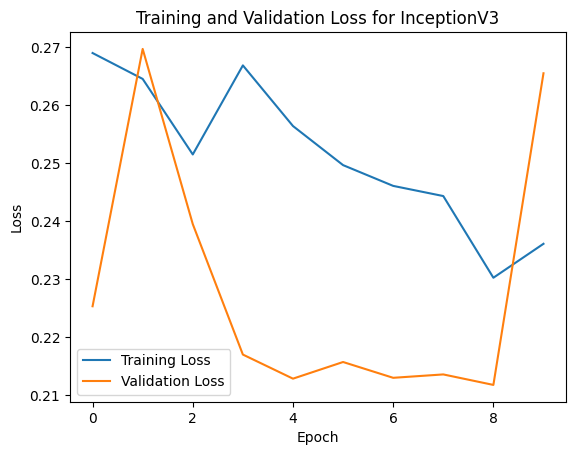

In [ ]:
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for InceptionV3')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = final_mobilev3.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


17/17 [==============================] - 3s 154ms/step


In [ ]:
# y_true = np.concatenate([y for x, y in test_generator], axis=0)
# cm = confusion_matrix(y_true, y_pred_classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix for MobileNetV3')
# plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_pred = inception_v3.predict(test_generator)
y_true = test_generator.classes

y_pred_classes = (y_pred > 0.4).astype(int)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))


17/17 [==============================] - 3s 196ms/step
                  precision    recall  f1-score   support

   WithPollution       0.39      0.29      0.33       238
WithoutPollution       0.51      0.62      0.56       287

        accuracy                           0.47       525
       macro avg       0.45      0.46      0.45       525
    weighted avg       0.46      0.47      0.46       525



In [ ]:
inception_v3.evaluate(test_generator)

17/17 [==============================] - 3s 172ms/step - loss: 0.2655 - accuracy: 0.8895


[0.2655308246612549, 0.8895238041877747]

In [ ]:
from tensorflow.keras.models import load_model

model_inception_v3 = load_model('/content/drive/MyDrive/PollutionDetection/vgg19.h5')

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
import numpy as np
from tensorflow.keras.preprocessing import image
img_path = '/content/drive/MyDrive/FinalDataset/SplittedDatasetFinal/SplittedDataset/test/WithPollution/Pol_110.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to (224, 224)

# Convert image to numpy array
image.load_img
# Expand dimensions to match the expected shape by the preprocess input function
img_array_expanded = np.expand_dims(img_array, axis=0)
preprocessed_img_inception_v3 = preprocess_input_inception_v3(img_array_expanded)
prediction_inception_v3 = model_inception_v3.predict(preprocessed_img_inception_v3)
class_names = ['WithoutPollution','WithPollution']

def get_class_label(prediction):
    if prediction >= 0.5:
        return class_names[0]  # WithPollution
    else:
        return class_names[1]  # WithoutPollution

class_prediction_inception_v3 = get_class_label(prediction_inception_v3)
print("Inception V3:", class_prediction_inception_v3)


1/1 [==============================] - 0s 151ms/step
Inception V3: WithPollution


## **VGG 16**

In [ ]:
from tensorflow.keras.applications import VGG16


def create_vgg16_model(input_shape):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

In [ ]:
input_shape = (224, 224, 3)

vgg16 = create_vgg16_model(input_shape)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
vgg16.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
initial_epochs = 20
history4 = vgg16.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/20
69/69 [==============================] - 59s 725ms/step - loss: 0.6242 - accuracy: 0.6411 - val_loss: 0.5362 - val_accuracy: 0.7448
Epoch 2/20
69/69 [==============================] - 43s 630ms/step - loss: 0.5278 - accuracy: 0.7387 - val_loss: 0.5379 - val_accuracy: 0.7181
Epoch 3/20
69/69 [==============================] - 41s 595ms/step - loss: 0.4733 - accuracy: 0.7754 - val_loss: 0.4204 - val_accuracy: 0.8095
Epoch 4/20
69/69 [==============================] - 43s 627ms/step - loss: 0.4367 - accuracy: 0.8040 - val_loss: 0.3858 - val_accuracy: 0.8286
Epoch 5/20
69/69 [==============================] - 41s 596ms/step - loss: 0.4572 - accuracy: 0.7840 - val_loss: 0.3631 - val_accuracy: 0.8381
Epoch 6/20
69/69 [==============================] - 41s 594ms/step - loss: 0.4307 - accuracy: 0.8140 - val_loss: 0.3798 - val_accuracy: 0.8381
Epoch 7/20
69/69 [==============================] - 52s 756ms/step - loss: 0.3927 - accuracy: 0.8294 - val_loss: 0.3601 - val_accuracy: 0.8495

In [ ]:
vgg16.save("/content/drive/MyDrive/PollutionDetection/vgg16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


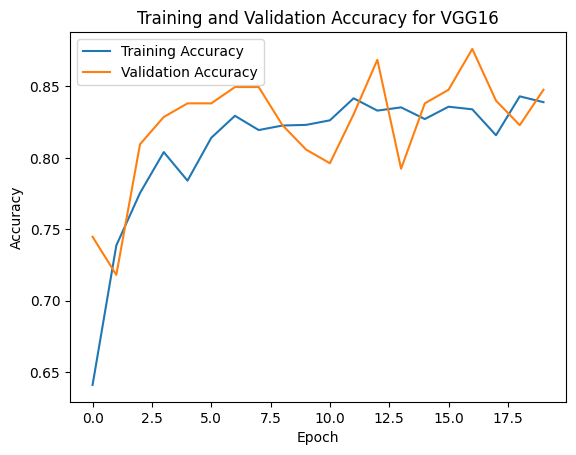

In [ ]:
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16')
plt.legend()
plt.show()

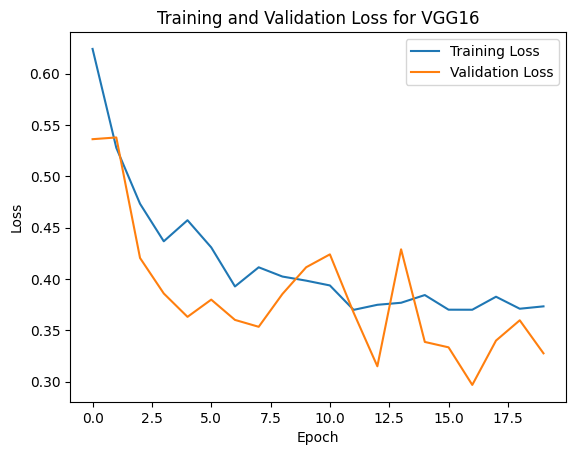

In [ ]:
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = vgg16.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_generator], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG16')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model_inception_v3 = load_model('/content/drive/MyDrive/PollutionDetection/vgg16.h5')

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
import numpy as np
from tensorflow.keras.preprocessing import image
img_path = '/content/drive/MyDrive/FinalDataset/SplittedDatasetFinal/SplittedDataset/test/WithoutPollution/rot_pos_15_NoPol_58.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to (224, 224)

# Convert image to numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the expected shape by the preprocess input function
img_array_expanded = np.expand_dims(img_array, axis=0)
preprocessed_img_inception_v3 = preprocess_input_inception_v3(img_array_expanded)
prediction_inception_v3 = model_inception_v3.predict(preprocessed_img_inception_v3)
class_names = ['WithoutPollution','WithPollution']

def get_class_label(prediction):
    if prediction >= 0.5:
        return class_names[0]  # WithPollution
    else:
        return class_names[1]  # WithoutPollution

class_prediction_inception_v3 = get_class_label(prediction_inception_v3)
print("VGG16:", class_prediction_inception_v3)


1/1 [==============================] - 0s 31ms/step
VGG16: WithoutPollution


## **VGG19**

In [ ]:
from tensorflow.keras.applications import VGG19


def create_vgg19_model(input_shape):
    base_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

In [ ]:
input_shape = (224, 224, 3)

vgg19 = create_vgg19_model(input_shape)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
vgg19.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
initial_epochs = 20
history5 = vgg19.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/20
69/69 [==============================] - 50s 714ms/step - loss: 0.6564 - accuracy: 0.6030 - val_loss: 0.5858 - val_accuracy: 0.7029
Epoch 2/20
69/69 [==============================] - 42s 603ms/step - loss: 0.5545 - accuracy: 0.7273 - val_loss: 0.5052 - val_accuracy: 0.7848
Epoch 3/20
69/69 [==============================] - 43s 623ms/step - loss: 0.5038 - accuracy: 0.7568 - val_loss: 0.4664 - val_accuracy: 0.8038
Epoch 4/20
69/69 [==============================] - 45s 647ms/step - loss: 0.4981 - accuracy: 0.7518 - val_loss: 0.5002 - val_accuracy: 0.7771
Epoch 5/20
69/69 [==============================] - 41s 587ms/step - loss: 0.4834 - accuracy: 0.7613 - val_loss: 0.4478 - val_accuracy: 0.8190
Epoch 6/20
69/69 [==============================] - 42s 613ms/step - loss: 0.4849 - accuracy: 0.7636 - val_loss: 0.4262 - val_accuracy: 0.8324
Epoch 7/20
69/69 [==============================] - 43s 630ms/step - loss: 0.4664 - accuracy: 0.7795 - val_loss: 0.4350 - val_accuracy: 0.8286

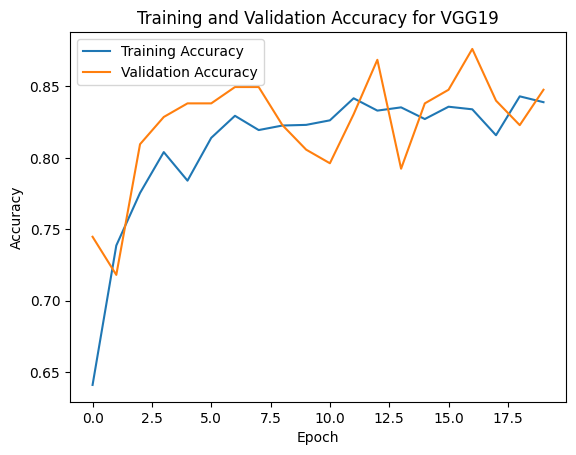

In [ ]:
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG19')
plt.legend()
plt.show()

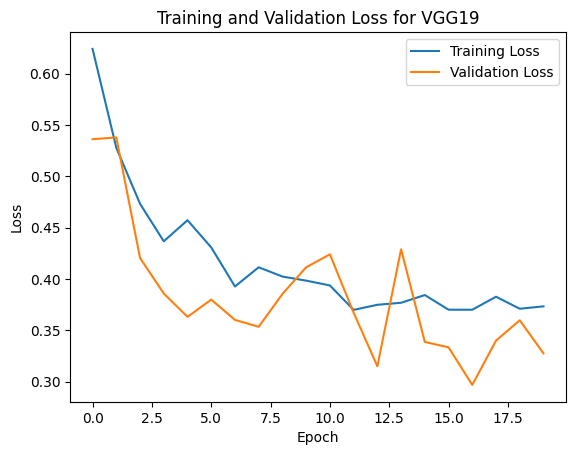

In [ ]:
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG19')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = vgg19.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_generator], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG19')
plt.show()

In [ ]:
vgg19.save("/content/drive/MyDrive/PollutionDetection/vgg19.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

vgg19 = load_model('/content/drive/MyDrive/PollutionDetection/vgg19.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
target_size = (224, 224)

img_path = "/content/drive/MyDrive/FinalDataset/SplittedDatasetFinal/SplittedDataset/test/WithPollution/Pol_NT_225.jpg"
img = image.load_img(img_path, target_size=target_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = vgg19.predict(img_array)

# Get the predicted class label
predicted_class = 'Not Polluted' if predictions[0] > 0.65 else 'Polluted'  # Adjust the threshold as needed

print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 48ms/step
Predicted class: Polluted


In [ ]:
from sklearn.metrics import classification_report
y_pred = vgg19.predict(test_generator)
y_true = test_generator.classes

y_pred_classes = (y_pred > 0.4).astype(int)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

17/17 [==============================] - 4s 188ms/step
                  precision    recall  f1-score   support

   WithPollution       0.45      0.29      0.36       238
WithoutPollution       0.55      0.71      0.62       287

        accuracy                           0.52       525
       macro avg       0.50      0.50      0.49       525
    weighted avg       0.51      0.52      0.50       525



## **InceptionTResnet-V2**

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load Test Dataset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2204 images belonging to 2 classes.
Found 525 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
def create_inception_resnet_v2_model(input_shape):
    base_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=outputs)

    return model


In [ ]:
input_shape = (299, 299, 3)

InceptionResNetV2 = create_inception_resnet_v2_model(input_shape)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
InceptionResNetV2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
InceptionResNetV2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

In [ ]:
initial_epochs = 20
history6 = InceptionResNetV2.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/20
69/69 [==============================] - 98s 1s/step - loss: 0.3919 - accuracy: 0.8149 - val_loss: 0.2429 - val_accuracy: 0.9010
Epoch 2/20
69/69 [==============================] - 70s 1s/step - loss: 0.2510 - accuracy: 0.9002 - val_loss: 0.2077 - val_accuracy: 0.9162
Epoch 3/20
69/69 [==============================] - 68s 989ms/step - loss: 0.2406 - accuracy: 0.9020 - val_loss: 0.2216 - val_accuracy: 0.9181
Epoch 4/20
69/69 [==============================] - 69s 1000ms/step - loss: 0.2957 - accuracy: 0.8693 - val_loss: 0.2168 - val_accuracy: 0.9143
Epoch 5/20
69/69 [==============================] - 70s 1s/step - loss: 0.2232 - accuracy: 0.9083 - val_loss: 0.2045 - val_accuracy: 0.9238
Epoch 6/20
69/69 [==============================] - 69s 1s/step - loss: 0.2297 - accuracy: 0.9025 - val_loss: 0.1881 - val_accuracy: 0.9238
Epoch 7/20
69/69 [==============================] - 68s 983ms/step - loss: 0.2099 - accuracy: 0.9192 - val_loss: 0.1748 - val_accuracy: 0.9295
Epoch 8/20

In [ ]:
InceptionResNetV2.save("/content/drive/MyDrive/PollutionDetection/InceptionResNetV2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


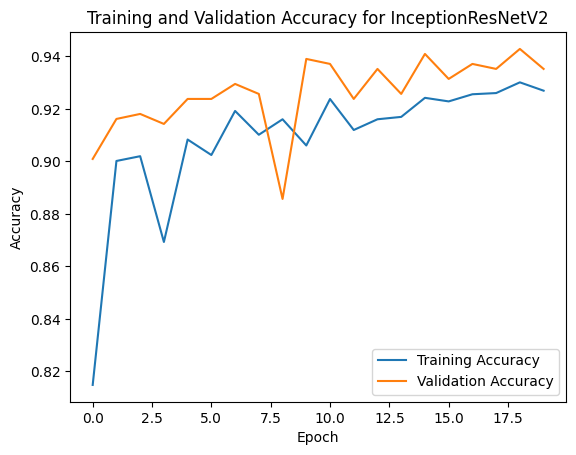

In [ ]:
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for InceptionResNetV2')
plt.legend()
plt.show()

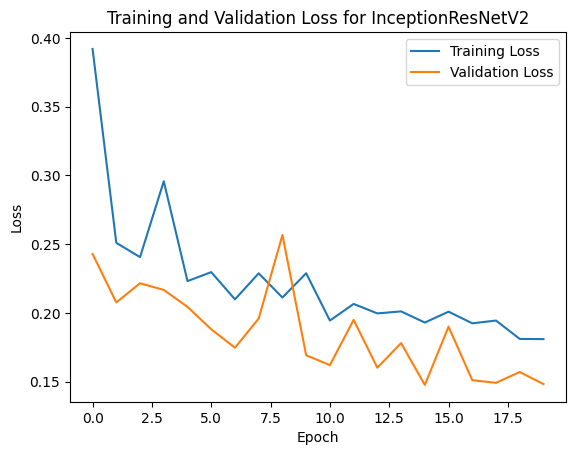

In [ ]:
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for InceptionResNetV2')
plt.legend()
plt.show()

## **XceptionNet Model**

In [ ]:
from tensorflow.keras.applications import Xception


def create_xception_model(input_shape):
    base_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model

In [ ]:
input_shape = (299, 299, 3)

xception_model = create_xception_model(input_shape)

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
xception_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [ ]:
initial_epochs = 10
history7 = xception_model.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)

Epoch 1/10
69/69 [==============================] - 1323s 19s/step - loss: 0.3377 - accuracy: 0.8548 - val_loss: 0.2029 - val_accuracy: 0.9143
Epoch 2/10
69/69 [==============================] - 66s 951ms/step - loss: 0.2453 - accuracy: 0.8966 - val_loss: 0.2164 - val_accuracy: 0.9162
Epoch 3/10
69/69 [==============================] - 64s 935ms/step - loss: 0.2167 - accuracy: 0.9147 - val_loss: 0.1652 - val_accuracy: 0.9333
Epoch 4/10
69/69 [==============================] - 66s 950ms/step - loss: 0.2005 - accuracy: 0.9211 - val_loss: 0.1538 - val_accuracy: 0.9410
Epoch 5/10
69/69 [==============================] - 65s 949ms/step - loss: 0.1946 - accuracy: 0.9238 - val_loss: 0.1804 - val_accuracy: 0.9219
Epoch 6/10
69/69 [==============================] - 66s 949ms/step - loss: 0.1812 - accuracy: 0.9283 - val_loss: 0.1542 - val_accuracy: 0.9429
Epoch 7/10
69/69 [==============================] - 66s 950ms/step - loss: 0.1937 - accuracy: 0.9220 - val_loss: 0.1484 - val_accuracy: 0.9467

In [ ]:
xception_model.save("/content/drive/MyDrive/PollutionDetection/XceptionModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


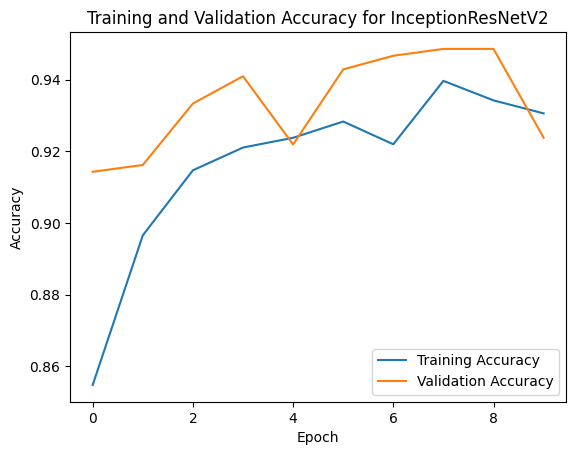

In [ ]:
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for InceptionResNetV2')
plt.legend()
plt.show()

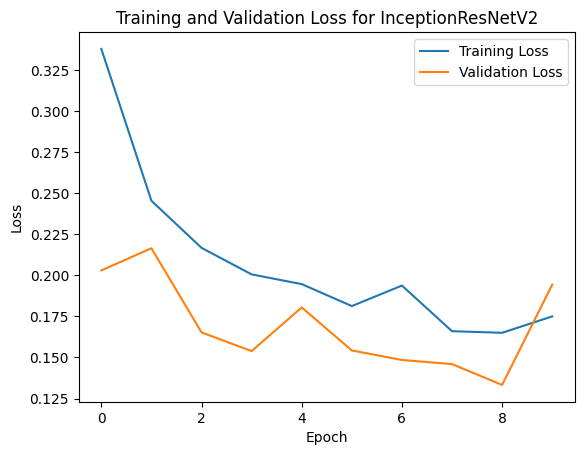

In [ ]:
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for InceptionResNetV2')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = xception_model.predict(test_generator)
y_true = test_generator.classes

y_pred_classes = (y_pred > 0.4).astype(int)


class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

17/17 [==============================] - 4s 238ms/step
                  precision    recall  f1-score   support

   WithPollution       0.45      0.36      0.40       238
WithoutPollution       0.54      0.63      0.58       287

        accuracy                           0.51       525
       macro avg       0.49      0.49      0.49       525
    weighted avg       0.50      0.51      0.50       525



## **Loading all the models  and making Predictions**

In [ ]:
#loading the models
from tensorflow.keras.models import load_model

model_mobilenet_v2 = load_model('/content/drive/MyDrive/PollutionDetection/MobileNetV2Model.h5')

model_mobilenet_v3 = load_model('/content/drive/MyDrive/PollutionDetection/MobileNetV3Model.h5')

model_inception_v3 = load_model('/content/drive/MyDrive/PollutionDetection/InceptionV3model.h5')

model_vgg16 = load_model('/content/drive/MyDrive/PollutionDetection/vgg16.h5')

model_vgg19 = load_model('/content/drive/MyDrive/PollutionDetection/vgg19.h5')

model_inception_resnet_v2 = load_model('/content/drive/MyDrive/PollutionDetection/InceptionResNetV2.h5')

model_xception = load_model('/content/drive/MyDrive/PollutionDetection/XceptionModel.h5')


In [ ]:
k=model_mobilenet_v2.evaluate(test_generator)[1]
print(k)

17/17 [==============================] - 184s 11s/step - loss: 0.7539 - accuracy: 0.5000
0.5


In [ ]:
models = [model_mobilenet_v2,model_mobilenet_v3,model_inception_v3,model_vgg16,model_vgg19,model_inception_resnet_v2,model_xception]
class_names = ['With Pollution','WithoutPollution']

# Xception Model

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

def xception(image_path, target_size=(299, 299), threshold=0.8):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_xception.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    print("Predicted confidence:", prediction[0][0])
    # print("Predicted class label:", class_names[class_label])
    return class_label

# VGG 16 Model

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def vgg16(image_path, target_size=(224, 224), threshold=0.8):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_vgg16.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    print("Predicted confidence:", prediction[0][0])
    # print("Predicted class label:", class_names[class_label])

    return class_label


# VGG 19

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def vgg19(image_path, target_size=(224, 224), threshold=0.8):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_vgg19.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    # print("Predicted class label:", class_names[class_label])
    print("Predicted confidence:", prediction[0][0])

    # Plot the image
    # plt.imshow(img)
    # plt.title(f"Predicted class: {class_names[class_label]}")
    # plt.axis('off')
    # plt.show()
    return class_label


# Inception V3

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def inception(image_path, target_size=(224, 224), threshold=0.8):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_inception_v3.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    # print("Predicted class label:", class_names[class_label])
    print("Predicted confidence:", prediction[0][0])

    # Plot the image
    # plt.imshow(img)
    # plt.title(f"Predicted class: {class_names[class_label]}")
    # plt.axis('off')
    # plt.show()
    return class_label


# Inception Resnet

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def inceptionResnet(image_path, target_size=(299, 299), threshold=0.8):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_inception_resnet_v2.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    print("Predicted confidence:", prediction[0][0])
    # print("Predicted class label:", class_names[class_label])

    # Plot the image
    # plt.imshow(img)
    # plt.title(f"Predicted class: {class_names[class_label]}")
    # plt.axis('off')
    # plt.show()
    return class_label

# MobileNet V2

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def mobilenetv2(image_path, target_size=(224, 224), threshold=1.0):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_mobilenet_v2.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    print("Predicted confidence:", prediction[0][0])
    # print("Predicted class label:", class_names[class_label])

    # Plot the image
    # plt.imshow(img)
    # plt.title(f"Predicted class: {class_names[class_label]}")
    # plt.axis('off')
    # plt.show()
    print(prediction)
    return class_label


# Mobile Net V3 Small

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def mobilenetv3(image_path, target_size=(224, 224), threshold=1.0):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model_mobilenet_v3.predict(img_array)
    class_label = 1 if prediction[0][0] > threshold else 0
    print("Predicted confidence:", prediction[0][0])
    return class_label

In [ ]:
def majority_voting(predictions):
    majority_vote = np.argmax(np.bincount(predictions))
    return majority_vote
def majority_predict(image_path):
    img = image.load_img(image_path)
    model_predictions = []
    model_predictions.append(mobilenetv2(image_path))
    model_predictions.append(mobilenetv3(image_path))
    model_predictions.append(vgg16(image_path))
    model_predictions.append(vgg19(image_path))
    model_predictions.append(xception(image_path))
    model_predictions.append(inceptionResnet(image_path))

    # Check for valid predictions
    valid_predictions = [pred for pred in model_predictions if pred is not None]

    if len(valid_predictions) == 0:
        print("No valid predictions found.")
        return

    # Perform majority voting
    majority_vote = majority_voting(valid_predictions)
    majority_vote_label = "Without Pollution" if majority_vote == 1 else "With Pollution"

    # Plot image with predictions
    plt.imshow(img)
    plt.title(f"Predicted Labels: {valid_predictions}\nMajority Vote: {majority_vote_label}")
    plt.axis('off')
    plt.show()
    return majority_vote

***Test cases***

1/1 [==============================] - 1s 1s/step
Predicted confidence: 0.1975641
[[0.1975641]]
1/1 [==============================] - 1s 955ms/step
Predicted confidence: -0.0146798855
1/1 [==============================] - 1s 653ms/step
Predicted confidence: 0.21363622
1/1 [==============================] - 1s 791ms/step
Predicted confidence: 0.7201849


1/1 [==============================] - 1s 1s/step
Predicted confidence: 0.86476713


1/1 [==============================] - 4s 4s/step
Predicted confidence: 0.46274492


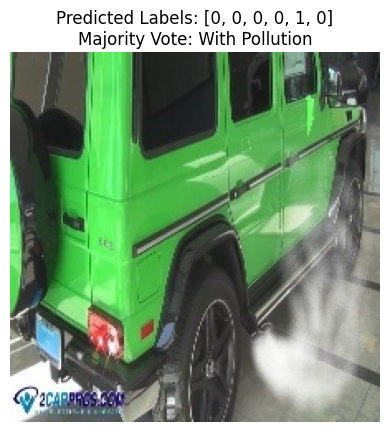

0


In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithPollution/Pol_166.jpg"
ret_val = majority_predict(path)
print(ret_val)

1/1 [==============================] - 0s 54ms/step
Predicted confidence: 0.82129663
[[0.82129663]]
1/1 [==============================] - 0s 41ms/step
Predicted confidence: -0.014589918
1/1 [==============================] - 0s 472ms/step
Predicted confidence: 0.9984195
1/1 [==============================] - 1s 614ms/step
Predicted confidence: 0.9959855
1/1 [==============================] - 0s 338ms/step
Predicted confidence: 0.99953073
1/1 [==============================] - 0s 480ms/step
Predicted confidence: 0.9999679


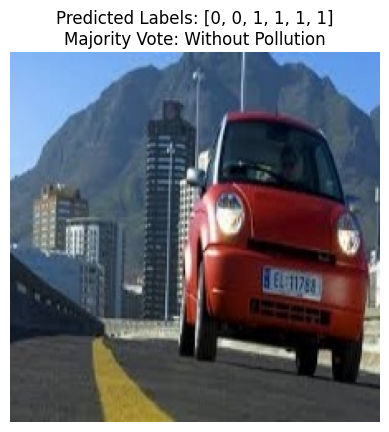

1

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithoutPollution/NoPol_119.jpg"
majority_predict(path)

1/1 [==============================] - 0s 78ms/step
Predicted confidence: 1.4521781
[[1.4521781]]
1/1 [==============================] - 0s 55ms/step
Predicted confidence: -0.014694198
1/1 [==============================] - 1s 660ms/step
Predicted confidence: 0.3923669
1/1 [==============================] - 1s 616ms/step
Predicted confidence: 0.40851516
1/1 [==============================] - 0s 344ms/step
Predicted confidence: 0.0013847571
1/1 [==============================] - 0s 481ms/step
Predicted confidence: 1.8199162e-05


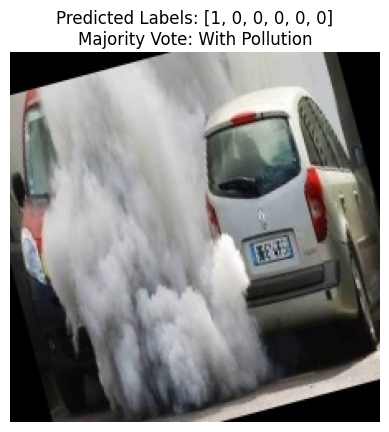

0

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithPollution/rot_pos_15_Pol_94.jpg"
majority_predict(path)

1/1 [==============================] - 0s 21ms/step
Predicted confidence: 1.6957738
1/1 [==============================] - 0s 28ms/step
Predicted confidence: -0.014625228
1/1 [==============================] - 0s 40ms/step
Predicted confidence: 0.99987805
1/1 [==============================] - 0s 20ms/step
Predicted confidence: 0.9975049
1/1 [==============================] - 0s 17ms/step
Predicted confidence: 0.9898022
1/1 [==============================] - 0s 24ms/step
Predicted confidence: 0.99913234


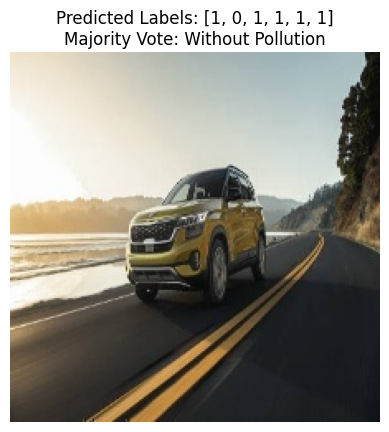

0

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithoutPollution/NoPol_180.jpg"
majority_predict(path)

1/1 [==============================] - 0s 93ms/step
Predicted confidence: 1.4143324
[[1.4143324]]
1/1 [==============================] - 0s 64ms/step
Predicted confidence: -0.014682424
1/1 [==============================] - 1s 685ms/step
Predicted confidence: 0.33486745
1/1 [==============================] - 1s 617ms/step
Predicted confidence: 0.5481413
1/1 [==============================] - 0s 323ms/step
Predicted confidence: 0.0025582365
1/1 [==============================] - 0s 495ms/step
Predicted confidence: 0.07777673


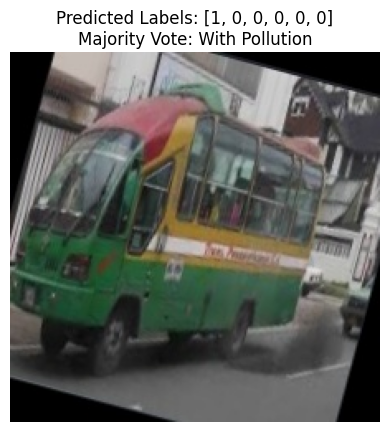

0

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithPollution/rot_neg_15_Pol_167.jpg"
majority_predict(path)

1/1 [==============================] - 0s 40ms/step
Predicted confidence: 1.30505
1/1 [==============================] - 0s 39ms/step
Predicted confidence: -0.01469374
1/1 [==============================] - 0s 65ms/step
Predicted confidence: 0.9998603
1/1 [==============================] - 0s 30ms/step
Predicted confidence: 0.97485715
1/1 [==============================] - 0s 28ms/step
Predicted confidence: 0.9439868
1/1 [==============================] - 0s 39ms/step
Predicted confidence: 0.99822253


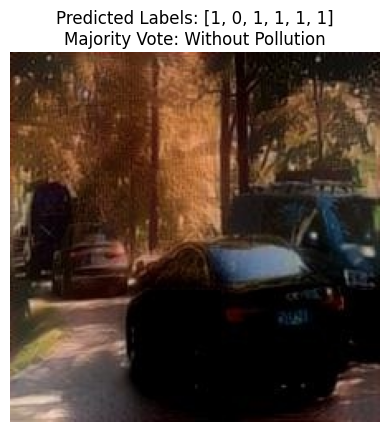

0

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithoutPollution/flip_NoPol_NT_354.jpg"
majority_predict(path)

1/1 [==============================] - 0s 55ms/step
Predicted confidence: 2.7235057
[[2.7235057]]
1/1 [==============================] - 0s 33ms/step
Predicted confidence: -0.014625232
1/1 [==============================] - 0s 477ms/step
Predicted confidence: 0.993278
1/1 [==============================] - 1s 614ms/step
Predicted confidence: 0.9971323
1/1 [==============================] - 0s 327ms/step
Predicted confidence: 0.3252149
1/1 [==============================] - 0s 481ms/step
Predicted confidence: 0.0027814314


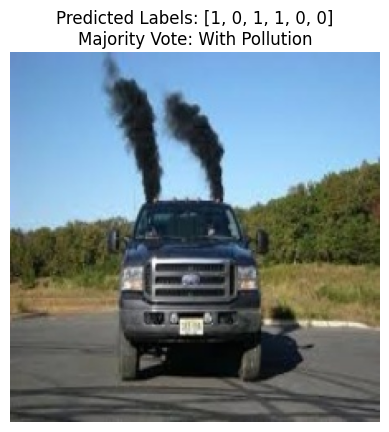

0

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithPollution/Pol_164.jpg"
majority_predict(path)

1/1 [==============================] - 0s 52ms/step
Predicted confidence: 1.483318
[[1.483318]]
1/1 [==============================] - 0s 34ms/step
Predicted confidence: -0.014719821
1/1 [==============================] - 0s 493ms/step
Predicted confidence: 0.80587316
1/1 [==============================] - 1s 599ms/step
Predicted confidence: 0.96732813
1/1 [==============================] - 0s 336ms/step
Predicted confidence: 0.99198765
1/1 [==============================] - 0s 469ms/step
Predicted confidence: 0.9103675


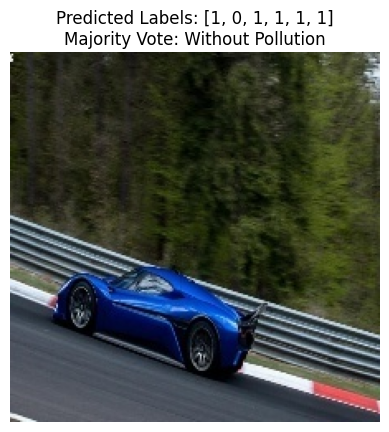

1

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/test/WithoutPollution/flip_NoPol_231.jpg"
majority_predict(path)

1/1 [==============================] - 0s 51ms/step
Predicted confidence: -0.22302619
[[-0.22302619]]
1/1 [==============================] - 0s 36ms/step
Predicted confidence: -0.014571166
1/1 [==============================] - 1s 807ms/step
Predicted confidence: 0.3025926
1/1 [==============================] - 1s 1s/step
Predicted confidence: 0.8003
1/1 [==============================] - 1s 550ms/step
Predicted confidence: 0.0044788024
1/1 [==============================] - 1s 809ms/step
Predicted confidence: 0.012011911


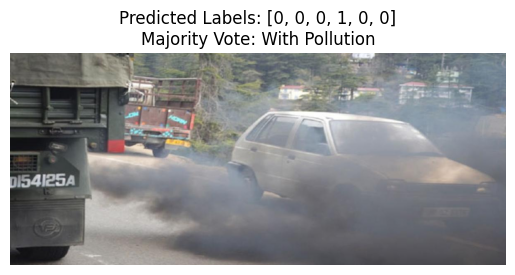

0

In [ ]:
path = "/content/drive/MyDrive/FinalDataset2/pollution pic.jpg"
majority_predict(path)

*Plotting Confusion Matrices**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_mat(my_model):
    predictions = my_model.predict(test_generator)
    predicted_labels = (predictions > 0.9).astype(int)
    true_labels = test_generator.classes
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    class_names = ['Without Pollution', 'With Pollution']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

17/17 [==============================] - 68s 792ms/step


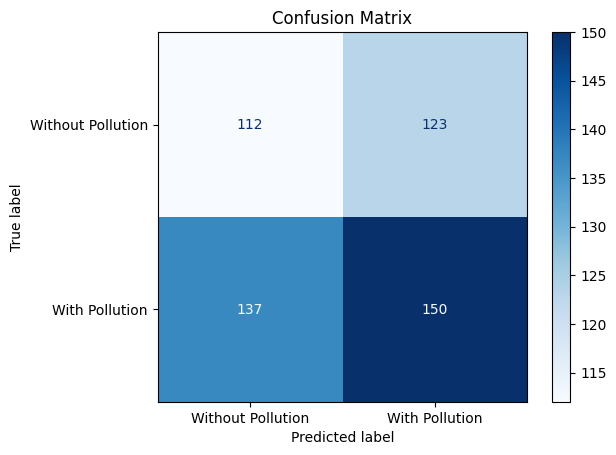

In [ ]:
plot_confusion_mat(model_xception)

17/17 [==============================] - 13s 750ms/step


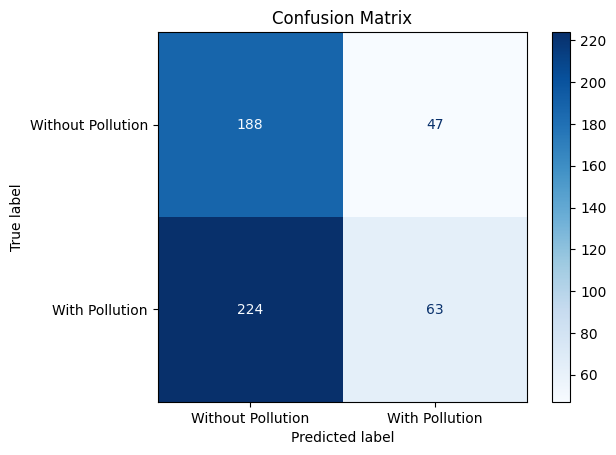

In [ ]:
plot_confusion_mat(model_vgg19)

## **Iterative Deep Training**

In [ ]:
#Loading The external Data
# img_path = "/content/drive/MyDrive/FinalDataset/SplittedDataset/ItrDeepTrain/NoPol_NT_303.jpg"
train_polluted = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution"
train_clean = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution"

In [ ]:
#loading data
def load_data(img_size):

    BATCH_SIZE = 32
    IMG_SIZE = img_size
    IMG_SHAPE = IMG_SIZE + (3,)

    directory = "/content/drive/MyDrive/FinalDataset2/SplittedDataset"
    train_dir = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train"
    test_dir = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/test"

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

In [ ]:
#all models re - train
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2,MobileNetV3Small,MobileNetV2,Xception,VGG16,VGG19,InceptionV3



def c_final_mobilev2(input_shape=IMG_SIZE):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    prediction_layer = tfl.Dense(1)

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model


def c_final_mobilev3(input_shape=IMG_SIZE):


    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    prediction_layer = tfl.Dense(1)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model


def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model


def create_vgg16_model(input_shape):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    return model
def create_vgg19_model(input_shape):
    base_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

def create_inception_resnet_v2_model(input_shape):
    base_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=outputs)

    return model


def create_xception_model(input_shape):
    base_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model


In [ ]:
def re_train(eps):
  IMG_SIZE = (224,224)
  input_shape = IMG_SIZE+(3,)
  load_data(IMG_SIZE)

  #inception V3
  final_inception = create_inceptionv3_model(input_shape)
  base_learning_rate = 0.001
  final_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_inception.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_inception.save("/content/drive/MyDrive/RetrainedModels/InceptionV3model.h5")
  plot_confusion_mat(final_inception)
  #VGG 16
  final_vgg16 = create_vgg16_model(input_shape)
  base_learning_rate = 0.001
  final_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_vgg16.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_vgg16.save("/content/drive/MyDrive/RetrainedModels/vgg16.h5")
  plot_confusion_mat(final_vgg16)
  #VGG 19
  final_vgg19 = create_vgg19_model(input_shape)
  base_learning_rate = 0.001
  final_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_vgg19.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_vgg19.save("/content/drive/MyDrive/RetrainedModels/vgg19.h5")
  plot_confusion_mat(final_vgg19)
  #mobile net v2
  final_mobilev2 = c_final_mobilev2(input_shape)
  base_learning_rate = 0.001
  final_mobilev2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_mobilev2.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_mobilev2.save("/content/drive/MyDrive/RetrainedModels/MobileNetV2Model.h5")
  plot_confusion_mat(final_mobilev2)
  #mobile net v3 small
  final_mobilev3 = c_final_mobilev3(input_shape)
  base_learning_rate = 0.001
  final_mobilev3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_mobilev3.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_mobilev3.save("/content/drive/MyDrive/RetrainedModels/MobilenetV3model.h5")
  plot_confusion_mat(final_mobilev3)

  #loading data for Inception Resnet V2 and Xception model of size (299,299)
  #Inception Resnet V2
  IMG_SIZE = (299,299)
  input_shape = IMG_SIZE+(3,)
  load_data(IMG_SIZE)
  final_inception_resnet = create_inception_resnet_v2_model(input_shape)
  base_learning_rate = 0.001
  final_inception_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_inception_resnet.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_inception_resnet.save("/content/drive/MyDrive/RetrainedModels/InceptionResnetV2.h5")
  plot_confusion_mat(final_inception_resnet)

  #Xception model
  final_xception = create_xception_model(input_shape)
  base_learning_rate = 0.001
  final_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  initial_epochs = eps
  history = final_xception.fit(train_generator, validation_data=test_generator, epochs=initial_epochs)
  final_xception.save("/content/drive/MyDrive/RetrainedModels/Xception.h5")
  plot_confusion_mat(final_xception)


In [ ]:
import os
import shutil

def move_img(image_path, target_directory):
    try:
        if not os.path.isfile(image_path):
            print(f"Error: Image file '{image_path}' does not exist.")
            return False
        if not os.path.isdir(target_directory):
            print(f"Error: Target directory '{target_directory}' does not exist.")
            return False
        image_filename = os.path.basename(image_path)

        shutil.move(image_path, os.path.join(target_directory, image_filename))

        print(f"Image '{image_filename}' moved to '{target_directory}'.")
        return True
    except Exception as e:
        print(f"Error: {e}")
        return False

1/1 [==============================] - 0s 25ms/step
Predicted confidence: 1.2609669
[[1.2609669]]
1/1 [==============================] - 0s 22ms/step
Predicted confidence: -0.014639507
1/1 [==============================] - 0s 19ms/step
Predicted confidence: 0.6089964
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.42344508
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.061216015
1/1 [==============================] - 0s 37ms/step
Predicted confidence: 0.07192933


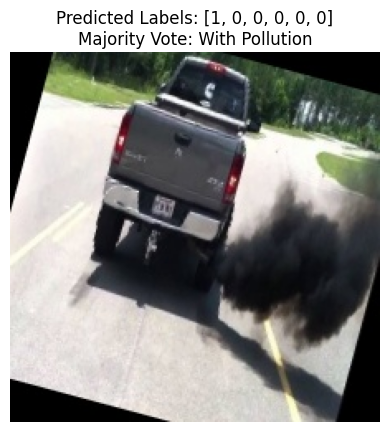

Image 'rot_neg_15_Pol_137.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 1.5156952
[[1.5156952]]
1/1 [==============================] - 0s 21ms/step
Predicted confidence: -0.0146396635
1/1 [==============================] - 0s 17ms/step
Predicted confidence: 0.9994836
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.99929297
1/1 [==============================] - 0s 23ms/step
Predicted confidence: 0.999711
1/1 [==============================] - 0s 36ms/step
Predicted confidence: 0.9994634


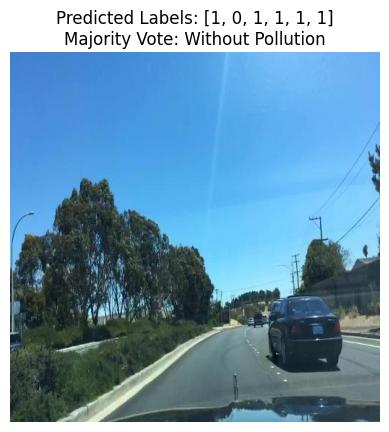

Image 'no_pol_60.png' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 54ms/step
Predicted confidence: -0.0107737165
[[-0.01077372]]
1/1 [==============================] - 0s 33ms/step
Predicted confidence: -0.014715361
1/1 [==============================] - 0s 45ms/step
Predicted confidence: 0.24988823
1/1 [==============================] - 0s 37ms/step
Predicted confidence: 0.18085952
1/1 [==============================] - 0s 47ms/step
Predicted confidence: 0.0060843467
1/1 [==============================] - 0s 68ms/step
Predicted confidence: 9.945784e-05


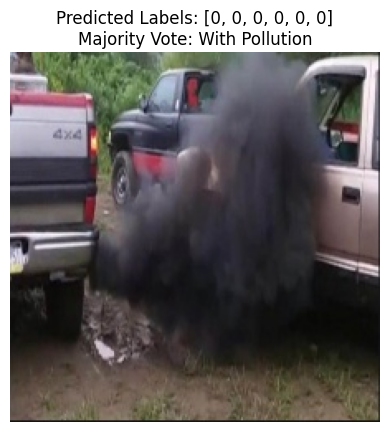

Image 'Pol_135.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 39ms/step
Predicted confidence: 0.77193916
[[0.77193916]]
1/1 [==============================] - 0s 34ms/step
Predicted confidence: -0.0146473
1/1 [==============================] - 0s 38ms/step
Predicted confidence: 0.8319658
1/1 [==============================] - 0s 34ms/step
Predicted confidence: 0.7998697
1/1 [==============================] - 0s 42ms/step
Predicted confidence: 0.0027369314
1/1 [==============================] - 0s 62ms/step
Predicted confidence: 2.1920812e-05


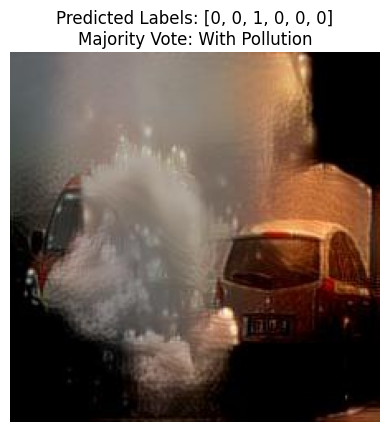

Image 'Pol_NT_235.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 28ms/step
Predicted confidence: 0.8022231
[[0.8022231]]
1/1 [==============================] - 0s 22ms/step
Predicted confidence: -0.014630604
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.95153975
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.89348507
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.98995847
1/1 [==============================] - 0s 39ms/step
Predicted confidence: 0.99632156


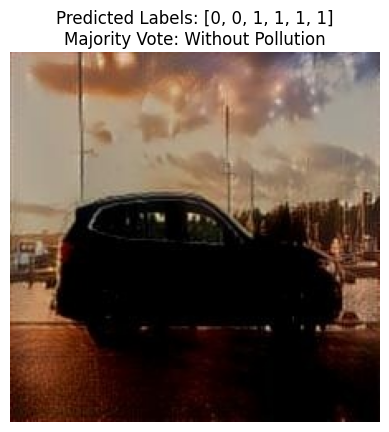

Image 'NoPol_NT_303.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.6224044
[[0.6224044]]
1/1 [==============================] - 0s 21ms/step
Predicted confidence: -0.0146044
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.8504092
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.82638127
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.9970343
1/1 [==============================] - 0s 39ms/step
Predicted confidence: 0.97611904


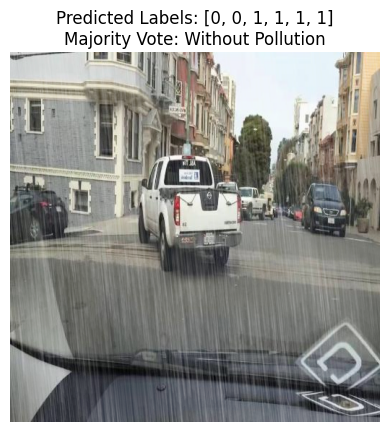

Image 'no_pol_54_rain_flip.png' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 22ms/step
Predicted confidence: 0.96556616
[[0.96556616]]
1/1 [==============================] - 0s 23ms/step
Predicted confidence: -0.014596219
1/1 [==============================] - 0s 17ms/step
Predicted confidence: 0.9853946
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.9790237
1/1 [==============================] - 0s 24ms/step
Predicted confidence: 0.99911493
1/1 [==============================] - 0s 40ms/step
Predicted confidence: 0.9893339


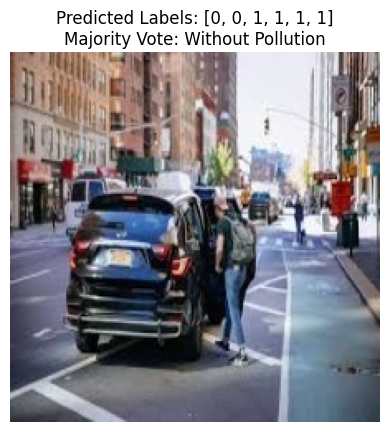

Image 'flip_NoPol_186.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.4460643
[[0.4460643]]
1/1 [==============================] - 0s 26ms/step
Predicted confidence: -0.014630309
1/1 [==============================] - 0s 18ms/step
Predicted confidence: 0.5949272
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.4393051
1/1 [==============================] - 0s 26ms/step
Predicted confidence: 0.041242883
1/1 [==============================] - 0s 46ms/step
Predicted confidence: 0.0017146326


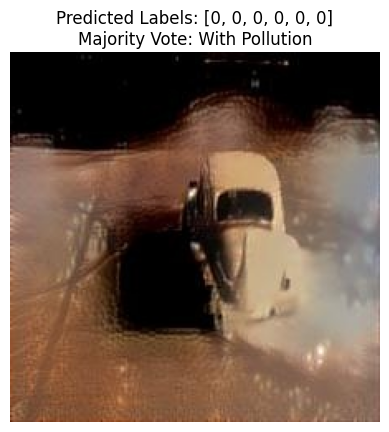

Image 'flip_Pol_NT_242.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 20ms/step
Predicted confidence: 1.9438312
[[1.9438312]]
1/1 [==============================] - 0s 22ms/step
Predicted confidence: -0.014632295
1/1 [==============================] - 0s 22ms/step
Predicted confidence: 0.9971583
1/1 [==============================] - 0s 26ms/step
Predicted confidence: 0.99093425
1/1 [==============================] - 0s 28ms/step
Predicted confidence: 0.9994443
1/1 [==============================] - 0s 52ms/step
Predicted confidence: 0.999629


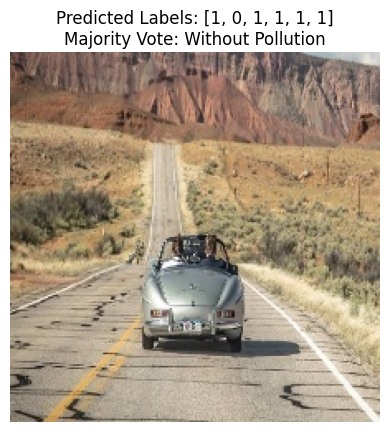

Image 'NoPol_99.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 37ms/step
Predicted confidence: 1.3033218
[[1.3033218]]
1/1 [==============================] - 0s 32ms/step
Predicted confidence: -0.014598484
1/1 [==============================] - 0s 35ms/step
Predicted confidence: 0.9897512
1/1 [==============================] - 0s 58ms/step
Predicted confidence: 0.959534
1/1 [==============================] - 0s 50ms/step
Predicted confidence: 0.9997788
1/1 [==============================] - 0s 105ms/step
Predicted confidence: 0.9997975


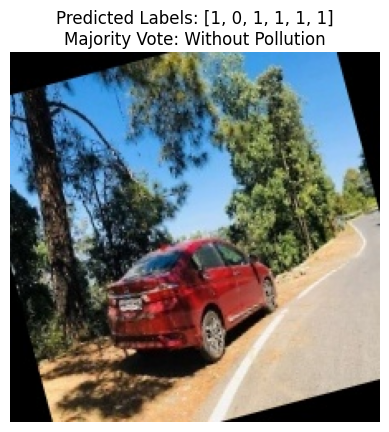

Image 'rot_pos_15_NoPol_11.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 35ms/step
Predicted confidence: 0.70530623
[[0.70530623]]
1/1 [==============================] - 0s 50ms/step
Predicted confidence: -0.014601751
1/1 [==============================] - 0s 37ms/step
Predicted confidence: 0.70870036
1/1 [==============================] - 0s 41ms/step
Predicted confidence: 0.89038897
1/1 [==============================] - 0s 64ms/step
Predicted confidence: 0.020349385
1/1 [==============================] - 0s 102ms/step
Predicted confidence: 0.00039131686


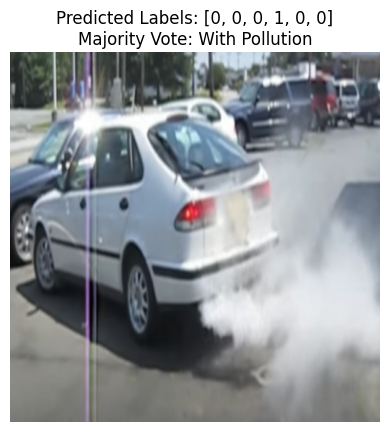

Image 'pol_4.png' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 34ms/step
Predicted confidence: 0.9143935
[[0.9143935]]
1/1 [==============================] - 0s 38ms/step
Predicted confidence: -0.014556046
1/1 [==============================] - 0s 39ms/step
Predicted confidence: 0.624616
1/1 [==============================] - 0s 26ms/step
Predicted confidence: 0.9495166
1/1 [==============================] - 0s 63ms/step
Predicted confidence: 0.009395412
1/1 [==============================] - 0s 107ms/step
Predicted confidence: 0.0009039897


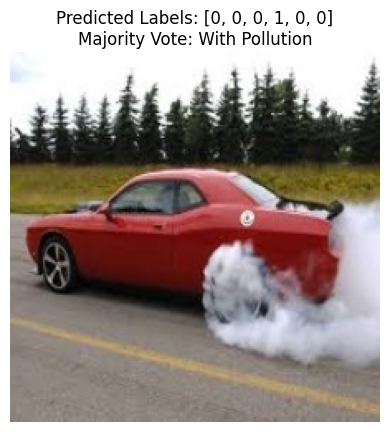

Image 'Pol_185.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 35ms/step
Predicted confidence: 0.8962127
[[0.8962127]]
1/1 [==============================] - 0s 64ms/step
Predicted confidence: -0.014628711
1/1 [==============================] - 0s 50ms/step
Predicted confidence: 0.755964
1/1 [==============================] - 0s 43ms/step
Predicted confidence: 0.33034682
1/1 [==============================] - 0s 44ms/step
Predicted confidence: 0.9475481
1/1 [==============================] - 0s 86ms/step
Predicted confidence: 0.65483683


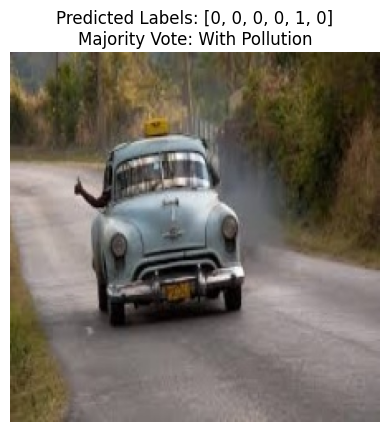

Image 'Pol_163.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 2.1115656
[[2.1115656]]
1/1 [==============================] - 0s 28ms/step
Predicted confidence: -0.014663654
1/1 [==============================] - 0s 27ms/step
Predicted confidence: 0.779738
1/1 [==============================] - 0s 31ms/step
Predicted confidence: 0.27421835
1/1 [==============================] - 0s 33ms/step
Predicted confidence: 0.99228114
1/1 [==============================] - 0s 59ms/step
Predicted confidence: 0.98853326


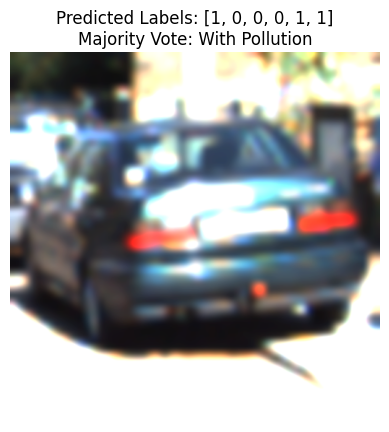

Image 'no_pol_51_blur_contrast.png' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 23ms/step
Predicted confidence: -0.1166693
[[-0.1166693]]
1/1 [==============================] - 0s 39ms/step
Predicted confidence: -0.014610118
1/1 [==============================] - 0s 29ms/step
Predicted confidence: 0.5769995
1/1 [==============================] - 0s 28ms/step
Predicted confidence: 0.65369695
1/1 [==============================] - 0s 35ms/step
Predicted confidence: 0.11523791
1/1 [==============================] - 0s 57ms/step
Predicted confidence: 0.0038713175


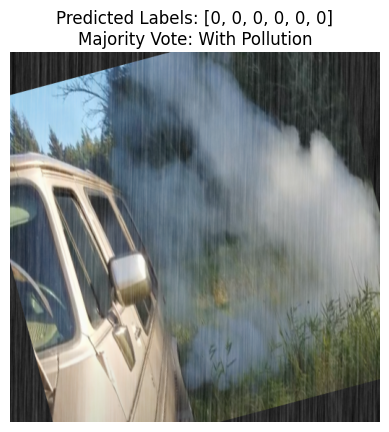

Image 'pol_59_rotation_rain.png' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 22ms/step
Predicted confidence: 0.37989044
[[0.37989044]]
1/1 [==============================] - 0s 31ms/step
Predicted confidence: -0.014698039
1/1 [==============================] - 0s 31ms/step
Predicted confidence: 0.9974323
1/1 [==============================] - 0s 31ms/step
Predicted confidence: 0.9757996
1/1 [==============================] - 0s 47ms/step
Predicted confidence: 0.9975501
1/1 [==============================] - 0s 55ms/step
Predicted confidence: 0.9891726


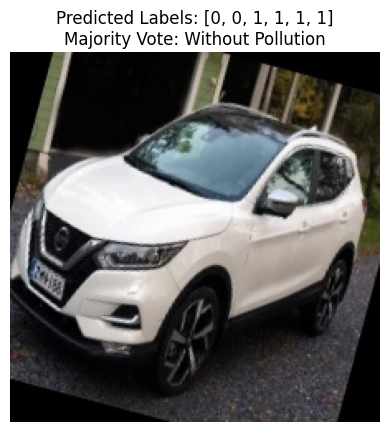

Image 'rot_neg_15_NoPol_110.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 1.0606712
[[1.0606712]]
1/1 [==============================] - 0s 32ms/step
Predicted confidence: -0.0147001995
1/1 [==============================] - 0s 36ms/step
Predicted confidence: 0.9904807
1/1 [==============================] - 0s 27ms/step
Predicted confidence: 0.9577193
1/1 [==============================] - 0s 33ms/step
Predicted confidence: 0.99851876
1/1 [==============================] - 0s 73ms/step
Predicted confidence: 0.9981165


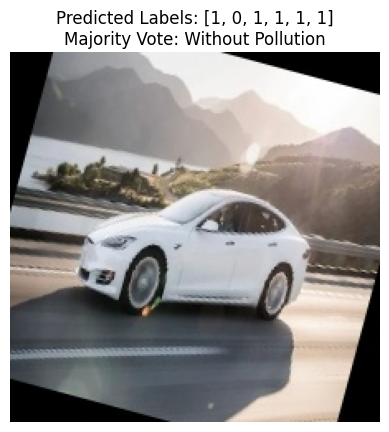

Image 'rot_neg_15_NoPol_15.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 21ms/step
Predicted confidence: 0.97688776
[[0.97688776]]
1/1 [==============================] - 0s 45ms/step
Predicted confidence: -0.0147324605
1/1 [==============================] - 0s 31ms/step
Predicted confidence: 0.9717397
1/1 [==============================] - 0s 29ms/step
Predicted confidence: 0.9365573
1/1 [==============================] - 0s 38ms/step
Predicted confidence: 0.99949086
1/1 [==============================] - 0s 60ms/step
Predicted confidence: 0.9930715


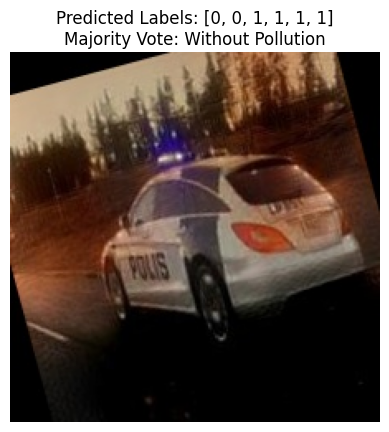

Image 'rot_pos_15_NoPol_NT_307.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 22ms/step
Predicted confidence: -0.04658407
[[-0.04658407]]
1/1 [==============================] - 0s 34ms/step
Predicted confidence: -0.014702371
1/1 [==============================] - 0s 30ms/step
Predicted confidence: 0.5109986
1/1 [==============================] - 0s 27ms/step
Predicted confidence: 0.29050314
1/1 [==============================] - 0s 31ms/step
Predicted confidence: 0.28874457
1/1 [==============================] - 0s 61ms/step
Predicted confidence: 0.511115


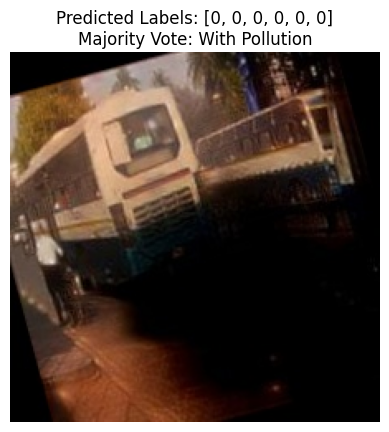

Image 'rot_pos_15_Pol_NT_202.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 24ms/step
Predicted confidence: 1.2462096
[[1.2462096]]
1/1 [==============================] - 0s 36ms/step
Predicted confidence: -0.014643955
1/1 [==============================] - 0s 33ms/step
Predicted confidence: 0.9589979
1/1 [==============================] - 0s 28ms/step
Predicted confidence: 0.966568
1/1 [==============================] - 0s 32ms/step
Predicted confidence: 0.9489821
1/1 [==============================] - 0s 60ms/step
Predicted confidence: 0.9741528


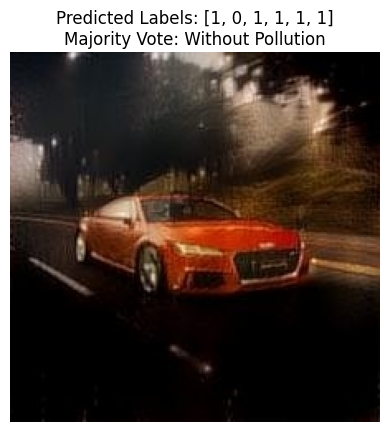

Image 'flip_NoPol_NT_349.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithoutPollution'.
1/1 [==============================] - 0s 46ms/step
Predicted confidence: 0.78153235
[[0.78153235]]
1/1 [==============================] - 0s 64ms/step
Predicted confidence: -0.014675493
1/1 [==============================] - 0s 27ms/step
Predicted confidence: 0.9255094
1/1 [==============================] - 0s 38ms/step
Predicted confidence: 0.9572014
1/1 [==============================] - 0s 52ms/step
Predicted confidence: 0.24476689
1/1 [==============================] - 0s 105ms/step
Predicted confidence: 0.5280209


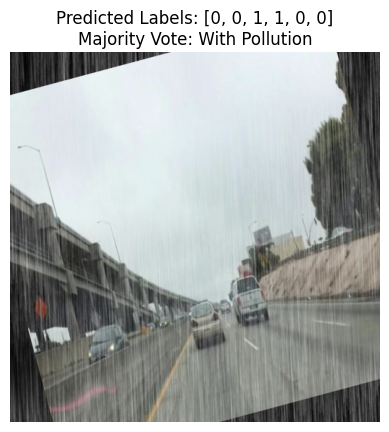

Image 'no_pol_59_rotation_rain.png' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
1/1 [==============================] - 0s 67ms/step
Predicted confidence: 0.044565767
[[0.04456577]]
1/1 [==============================] - 0s 38ms/step
Predicted confidence: -0.014704472
1/1 [==============================] - 0s 40ms/step
Predicted confidence: 0.7504648
1/1 [==============================] - 0s 39ms/step
Predicted confidence: 0.46251598
1/1 [==============================] - 0s 38ms/step
Predicted confidence: 0.030567931
1/1 [==============================] - 0s 101ms/step
Predicted confidence: 0.11059442


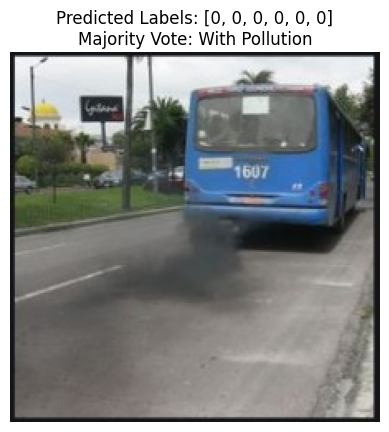

Image 'Pol_87.jpg' moved to '/content/drive/MyDrive/FinalDataset2/SplittedDataset/SplittedDataset/train/WithPollution'.
Retraining all the models!!
Found 2250 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 59s 753ms/step - loss: 0.4917 - accuracy: 0.7648 - val_loss: 1.4977 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 63s 884ms/step - loss: 0.3369 - accuracy: 0.8572 - val_loss: 1.8618 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 53s 747ms/step - loss: 0.2962 - accuracy: 0.8715 - val_loss: 1.5856 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 52s 730ms/step - loss: 0.3015 - accuracy: 0.8706 - val_loss: 1.7205 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 53s 753ms/step - loss: 0.3343 - accuracy: 0.8621 - val_loss: 1.7718 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 51s 721ms/step - loss: 0.2932 - accuracy: 0.8728 - val_loss: 1.6913 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 52s 730ms/step - loss: 0.3378 - accuracy: 0.8545 - val_loss: 1.9053 - val_accuracy: 0.5000
Epoch 8/15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 10s 514ms/step


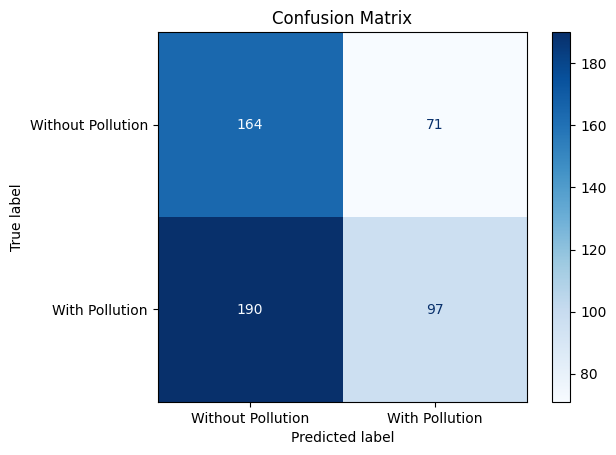

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 62s 777ms/step - loss: 0.6005 - accuracy: 0.6845 - val_loss: 0.8287 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 51s 721ms/step - loss: 0.5211 - accuracy: 0.7488 - val_loss: 0.8659 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 52s 727ms/step - loss: 0.4796 - accuracy: 0.7876 - val_loss: 0.9322 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 52s 719ms/step - loss: 0.4571 - accuracy: 0.7916 - val_loss: 0.9859 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 51s 725ms/step - loss: 0.4458 - accuracy: 0.7996 - val_loss: 0.9924 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 52s 736ms/step - loss: 0.4206 - accuracy: 0.8121 - val_loss: 1.0265 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 50s 706ms/step - loss: 0.4381 - accuracy: 0.8005 - val_loss: 1.0451 - val_accuracy: 0.5000
Epoch 8/15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 10s 604ms/step


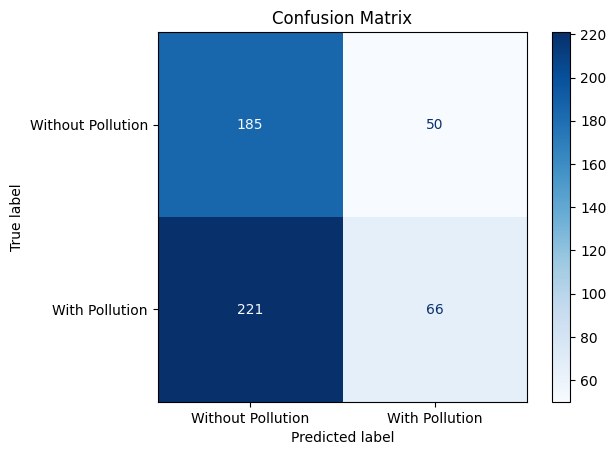

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 54s 738ms/step - loss: 0.6563 - accuracy: 0.6064 - val_loss: 0.7820 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 51s 722ms/step - loss: 0.5634 - accuracy: 0.7117 - val_loss: 0.8981 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 53s 742ms/step - loss: 0.5314 - accuracy: 0.7376 - val_loss: 0.9084 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 51s 724ms/step - loss: 0.4924 - accuracy: 0.7613 - val_loss: 0.9648 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 52s 732ms/step - loss: 0.4884 - accuracy: 0.7622 - val_loss: 1.0023 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 50s 702ms/step - loss: 0.4772 - accuracy: 0.7742 - val_loss: 1.0089 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 51s 719ms/step - loss: 0.4733 - accuracy: 0.7729 - val_loss: 1.0106 - val_accuracy: 0.5000
Epoch 8/15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 10s 614ms/step


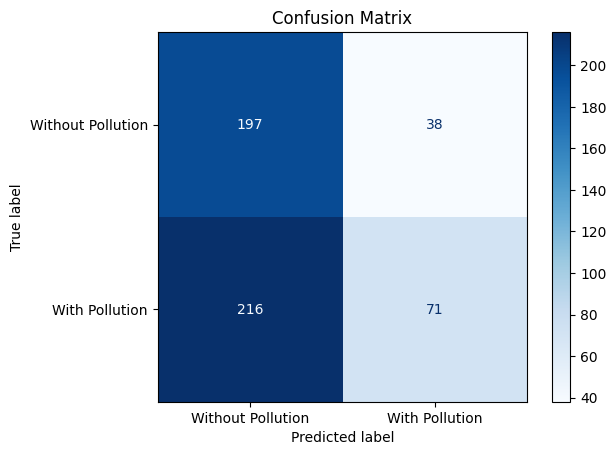

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/15
71/71 [==============================] - 54s 694ms/step - loss: 0.7210 - accuracy: 0.4668 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 50s 711ms/step - loss: 0.7150 - accuracy: 0.4909 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 49s 693ms/step - loss: 0.7006 - accuracy: 0.4967 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 48s 673ms/step - loss: 0.6914 - accuracy: 0.5341 - val_loss: 0.7132 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 49s 699ms/step - loss: 0.6806 - accuracy: 0.5163 - val_loss: 0.7033 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 48s 677ms/step - loss: 0.6716 - accuracy: 0.5422 - val_loss: 0.7021 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 53s 745ms/step - loss: 0.66

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 10s 525ms/step


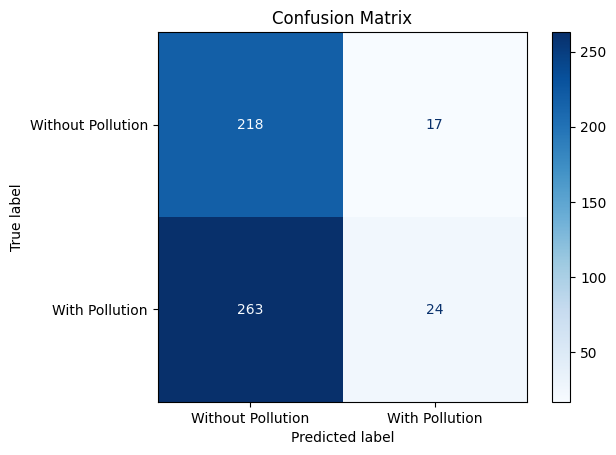

4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/15
71/71 [==============================] - 55s 712ms/step - loss: 0.6969 - accuracy: 0.4685 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 48s 671ms/step - loss: 0.6963 - accuracy: 0.4578 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 49s 696ms/step - loss: 0.6984 - accuracy: 0.4618 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 47s 663ms/step - loss: 0.6955 - accuracy: 0.4654 - val_loss: 0.7073 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 48s 681ms/step - loss: 0.6951 - accuracy: 0.4636 - val_loss: 0.6993 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 48s 688ms/step - loss: 0.6930 - accuracy: 0.4596 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 48s 681ms/step - loss: 0.69

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 9s 505ms/step


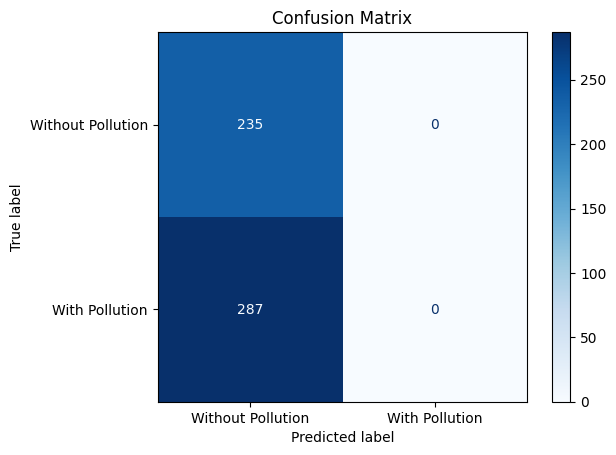

Found 2250 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
219055592/219055592 [==============================] - 2s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 73s 836ms/step - loss: 0.5288 - accuracy: 0.7577 - val_loss: 1.3898 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 53s 748ms/step - loss: 0.3300 - accuracy: 0.8536 - val_loss: 1.5919 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 53s 746ms/step - loss: 0.3115 - accuracy: 0.8630 - val_loss: 1.6537 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 55s 774ms/step - loss: 0.2797 - accuracy: 0.8768 - val_loss: 1.8102 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 53s 748ms/step - loss: 0.2871 - accuracy: 0.8844 - val_loss: 1.8283 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 53s 750ms/step - loss: 0.2683 - accuracy: 0.8893 - val_loss: 1.8612 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 54s 762ms/step - loss: 0.2873 - accuracy: 0.8764 - val_loss: 1.9249 - val_accuracy: 0.5000
Epoch 8/15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 14s 634ms/step


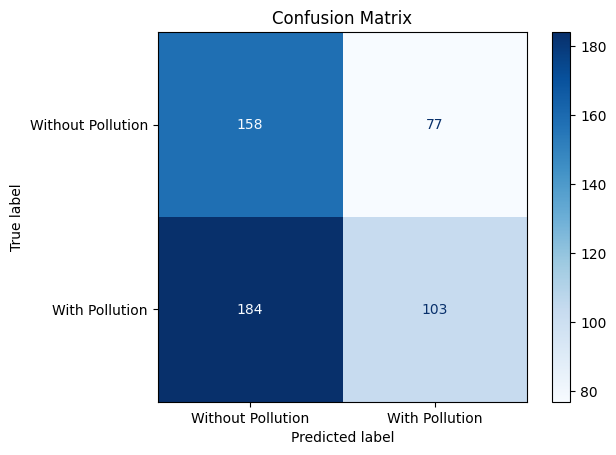

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 60s 769ms/step - loss: 0.4037 - accuracy: 0.8130 - val_loss: 1.5110 - val_accuracy: 0.5000
Epoch 2/15
71/71 [==============================] - 51s 719ms/step - loss: 0.2907 - accuracy: 0.8782 - val_loss: 1.8055 - val_accuracy: 0.5000
Epoch 3/15
71/71 [==============================] - 51s 724ms/step - loss: 0.3175 - accuracy: 0.8630 - val_loss: 1.5888 - val_accuracy: 0.5000
Epoch 4/15
71/71 [==============================] - 54s 757ms/step - loss: 0.2531 - accuracy: 0.8974 - val_loss: 1.8977 - val_accuracy: 0.5000
Epoch 5/15
71/71 [==============================] - 51s 724ms/step - loss: 0.2294 - accuracy: 0.9090 - val_loss: 1.9155 - val_accuracy: 0.5000
Epoch 6/15
71/71 [==============================] - 52s 738ms/step - loss: 0.2436 - accuracy: 0.9014 - val_loss: 1.9102 - val_accuracy: 0.5000
Epoch 7/15
71/71 [==============================] - 52s 728ms/step - loss: 0.2082 - accuracy: 0.9116 - val_loss: 2.0469 - val_accuracy: 0.5000
Epoch 8/15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 10s 547ms/step


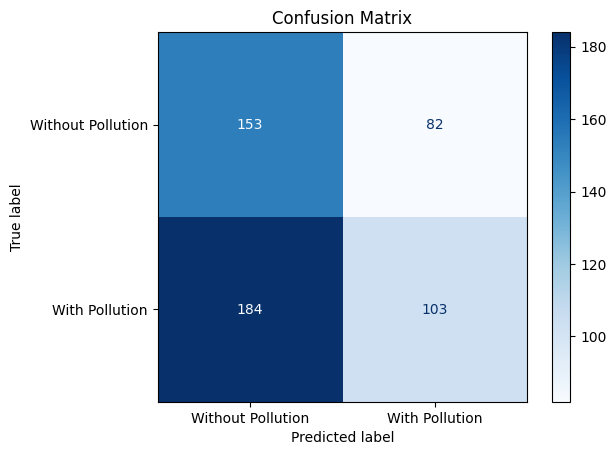

Completed!!


In [ ]:
import os
import shutil
max_itr = 1
eps = 15
itr_path = "/content/drive/MyDrive/FinalDataset2/SplittedDataset/ItrDeepTrainMain"
folders = os.listdir(itr_path)
for i in range(max_itr):
    for j in folders:
      f_path = itr_path+"/"+j+"/"
      f_imgs = os.listdir(f_path)
      for k in f_imgs:
        fin_image_path = f_path+k
        predicted_label = majority_predict(fin_image_path)
        if predicted_label == 1:
          move_img(fin_image_path,train_clean)
        else:
          move_img(fin_image_path,train_polluted)
    print("Retraining all the models!!")
    re_train(eps)
    print("Completed!!")